In [2]:
import numpy as np
import pandas as pd

import scipy.stats as st

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import matplotlib as mpl
sns.reset_orig()
sns.set_style('white')
mpl.rcParams['pdf.fonttype'] = 42

### Define feature sets

In [38]:
prot_feat_arr = ['Degree','Betweenness','Closeness','Eigenvector',
                 'ClusteringCoeff','Load', 'Pagerank']
print('# Protein-level features (Prot): %s' % len(prot_feat_arr))

res_feat_arr = ['3DLoc_Annot',
                'Degree_Change','Betweenness_Change','Closeness_Change','Eigenvector_Change',
                'ClusteringCoeff_Change','Load_Change', 'Pagerank_Change', 'Percent_Degree_Change']
print('# Residue-level features (Res): %s' % len(res_feat_arr))

net_feat_arr = prot_feat_arr+res_feat_arr
print('# Network-based features (Net=Prot+Res): %s' % len(net_feat_arr))

net_feat_arr2 = ['Degree','Betweenness','Closeness','Eigenvector',
                'ClusteringCoeff','Load', 'Pagerank',
                '3DLoc_Annot','Percent_Degree_Change',
                'Degree_Change','Betweenness_Change','Closeness_Change','Eigenvector_Change',
                'ClusteringCoeff_Change','Load_Change', 'Pagerank_Change']
print('# Network-based features (Net=Prot+Res): %s' % len(net_feat_arr))

aa_feat_arr = ['AABLOSUM', 'AACharge', 'AACOSMIC', 'AACOSMICvsHapMap', 'AACOSMICvsSWISSPROT', 'AAEx', 
               'AAGrantham', 'AAHapMap', 'AAHGMD2003', 'AAHydrophobicity', 'AAMJ', 'AAPAM250', 'AAPolarity', 
               'AATransition', 'AATripletFirstDiffProb', 'AATripletFirstProbMut', 'AATripletFirstProbWild', 
               'AATripletSecondDiffProb', 'AATripletSecondProbMut', 'AATripletSecondProbWild', 
               'AATripletThirdDiffProb', 'AATripletThirdProbMut', 'AATripletThirdProbWild', 'AAVB', 'AAVolume', 
               'ExonConservation', 'ExonHapMapSnpDensity', 'ExonSnpDensity', 'HMMEntropy', 'HMMPHC', 
               'HMMRelEntropy', 'MGAEntropy', 'MGAPHC', 'MGARelEntropy', 'PredBFactorF', 'PredBFactorM', 
               'PredBFactorS', 'PredRSAB', 'PredRSAE', 'PredRSAI', 'PredSSC', 'PredSSE', 'PredSSH', 
               'PredStabilityH', 'PredStabilityL', 'PredStabilityM', 'RegCompC', 'RegCompDE', 'RegCompEntropy', 
               'RegCompG', 'RegCompH', 'RegCompILVM', 'RegCompKR', 'RegCompNormEntropy', 'RegCompP', 'RegCompQ', 
               'RegCompWYF', 'UniprotACTSITE', 'UniprotBINDING', 'UniprotCABIND', 'UniprotCARBOHYD', 
               'UniprotCOMPBIAS', 'UniprotDISULFID', 'UniprotDNABIND', 'UniprotDOM_Chrom', 'UniprotDOM_LOC', 
               'UniprotDOM_MMBRBD', 'UniprotDOM_PostModEnz', 'UniprotDOM_PostModRec', 'UniprotDOM_PPI', 
               'UniprotDOM_RNABD', 'UniprotDOM_TF', 'UniprotLIPID', 'UniprotMETAL', 'UniprotMODRES', 
               'UniprotMOTIF', 'UniprotNPBIND', 'UniprotPROPEP', 'UniprotREGIONS', 'UniprotREP', 'UniprotSECYS', 
               'UniprotSIGNAL', 'UniprotSITE', 'UniprotTRANSMEM', 'UniprotZNFINGER']
# Remove these 2 features from aa_feat_arr because they had NaN values for all mutations
aa_feat_arr.remove('UniprotLIPID')
aa_feat_arr.remove('UniprotSECYS')
print('# Classic amino acid features (AA): %s' % len(aa_feat_arr))

tot_feat_arr = net_feat_arr2 + aa_feat_arr
print('# All features (Net+AA): %s' % len(tot_feat_arr))

# Protein-level features (Prot): 7
# Residue-level features (Res): 9
# Network-based features (Net=Prot+Res): 16
# Network-based features (Net=Prot+Res): 16
# Classic amino acid features (AA): 83
# All features (Net+AA): 99


### Read training set for Cancer using SRNet (driver vs. passenger mutations)
#### Read all mutations with raw feature values

In [5]:
# Define positive and negative mutation classes
pos, neg = 'Driver', 'Passenger'

In [6]:
# read all raw features
total_df = pd.read_table('../data/SRNet_cancer_features_all_raw.txt')
print(total_df.shape)
print('# driver mutations: %s' % len(total_df[total_df['Mut_type']==pos]))
print('# passenger mutations: %s' % len(total_df[total_df['Mut_type']==neg]))
print('# all mutations: %s' % len(total_df))
total_df.head()

(29004, 105)
# driver mutations: 961
# passenger mutations: 28043
# all mutations: 29004


,Mut_type,UID,Unip,Accession,Res,AA_Change,3DLoc_Annot,Degree,Betweenness,Closeness,...,UniprotMODRES,UniprotMOTIF,UniprotNPBIND,UniprotPROPEP,UniprotREGIONS,UniprotREP,UniprotSIGNAL,UniprotSITE,UniprotTRANSMEM,UniprotZNFINGER
0,Driver,1,O00255,ENST00000337652,160,S160F,I,3,0.002346,0.082899,...,0,0,0,0,0,0,0,0,0,0
1,Driver,2,O00255,ENST00000337652,362,D362H,C,3,0.002346,0.082899,...,0,0,0,0,1,0,0,0,0,0
2,Driver,3,O00255,ENST00000337652,184,E184K,I,3,0.002346,0.082899,...,0,0,0,0,0,0,0,0,0,0
3,Driver,4,O15169,ENST00000262320,120,A120D,I,5,0.004507,0.098816,...,0,0,0,0,0,0,0,0,0,0
4,Driver,6,O15169,ENST00000262320,193,M193K,C,5,0.004507,0.098816,...,0,0,0,0,0,0,0,0,0,0


### Read training set for Germline using SRNet (pathogenic vs. neutral variants)
#### Read all variants with raw feature values

In [7]:
# Define positive and negative mutation classes
pos, neg = 'Pathogenic', 'Common'

In [8]:
# read normalized features
total_df_2 = pd.read_table('../data/SRNet_germline_features_all_raw.txt')
print(total_df_2.shape)
print('# pathogenic variants: %s' % len(total_df_2[total_df_2['Mut_type']==pos]))
print('# neutral variants: %s' % len(total_df_2[total_df_2['Mut_type']==neg]))
print('# all variants: %s' % len(total_df_2))
total_df_2.head()

(9026, 106)
# pathogenic variants: 5608
# neutral variants: 3418
# all variants: 9026


,Index,Mut_type,UID,Unip,Accession,Res,AA_Change,3DLoc_Annot,Degree,Betweenness,...,UniprotMODRES,UniprotMOTIF,UniprotNPBIND,UniprotPROPEP,UniprotREGIONS,UniprotREP,UniprotSIGNAL,UniprotSITE,UniprotTRANSMEM,UniprotZNFINGER
0,0,Pathogenic,2,Q30201,NM_000410,282,C282Y,C,2,0.000526,...,0,0,0,0,1,0,0,0,0,0
1,1,Pathogenic,3,Q30201,NM_000410,63,H63D,S,2,0.000526,...,0,0,0,0,1,0,0,0,0,0
2,2,Pathogenic,4,Q30201,NM_000410,105,I105T,C,2,0.000526,...,0,0,0,0,1,0,0,0,0,0
3,3,Pathogenic,5,Q30201,NM_000410,93,G93R,I,2,0.000526,...,0,0,0,0,1,0,0,0,0,0
4,4,Pathogenic,6,Q30201,NM_000410,127,Q127H,S,2,0.000526,...,0,0,0,0,1,0,0,0,0,0


### Combine the 2 datasets

In [83]:
df = pd.concat([total_df, total_df_2], ignore_index=True, sort=False)
print(df.shape)

(38030, 106)


In [13]:
cats = ['Driver','Passenger','Pathogenic','Common']

driver_3d_c = list(df[df['Mut_type']=='Driver']['3DLoc_Annot'].values)
pass_3d_c = list(df[df['Mut_type']=='Passenger']['3DLoc_Annot'].values)
driver_3d_v = list(df[df['Mut_type']=='Pathogenic']['3DLoc_Annot'].values)
pass_3d_v = list(df[df['Mut_type']=='Common']['3DLoc_Annot'].values)

c_per = [(driver_3d_c.count('C')*100.0)/len(driver_3d_c), (pass_3d_c.count('C')*100.0)/len(pass_3d_c),
          (driver_3d_v.count('C')*100.0)/len(driver_3d_v), (pass_3d_v.count('C')*100.0)/len(pass_3d_v)]
i_per = [(driver_3d_c.count('I')*100.0)/len(driver_3d_c), (pass_3d_c.count('I')*100.0)/len(pass_3d_c),
          (driver_3d_v.count('I')*100.0)/len(driver_3d_v), (pass_3d_v.count('I')*100.0)/len(pass_3d_v)]
s_per = [(driver_3d_c.count('S')*100.0)/len(driver_3d_c), (pass_3d_c.count('S')*100.0)/len(pass_3d_c),
          (driver_3d_v.count('S')*100.0)/len(driver_3d_v), (pass_3d_v.count('S')*100.0)/len(pass_3d_v)]

### Figure 4a-c

In [26]:
mpl.rc('figure', titlesize=6)
mpl.rc('axes', labelsize=7, titlesize=6)
mpl.rc('xtick', labelsize=5)
mpl.rc('ytick', labelsize=4.5)
mpl.rc('legend', fontsize=6)

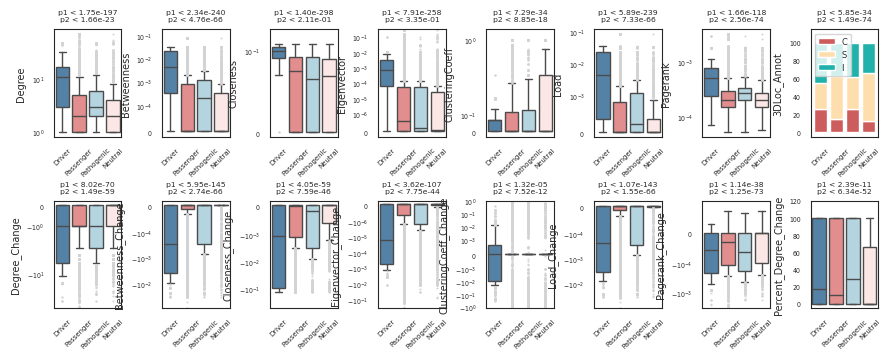

In [29]:
flierprops = dict(markerfacecolor = 'lightgrey', markeredgecolor='lightgrey', markersize = 0.5)
pal = ['steelblue','lightcoral','lightblue','mistyrose']

fig = plt.figure(figsize=(9, 3.7))

for idx, feat_arr in enumerate(net_feat_arr):
    (a,p1) = st.mannwhitneyu(df[df['Mut_type']=='Driver'][feat_arr],
                             df[df['Mut_type']=='Passenger'][feat_arr])
    (a,p2) = st.mannwhitneyu(df[df['Mut_type']=='Pathogenic'][feat_arr],
                             df[df['Mut_type']=='Common'][feat_arr])
    
    ax = plt.subplot(2, 8, idx+1)
    if feat_arr=='3DLoc_Annot':
        plt.bar(cats, c_per, label='C', color='indianred')
        plt.bar(cats, s_per, label='S', color='navajowhite', bottom=c_per)
        plt.bar(cats, i_per, label='I', color='lightseagreen', bottom=[i+j for i,j in zip(c_per, s_per)])
        plt.legend()
        plt.ylim(-5,115)
    else:
        ax = sns.boxplot(x='Mut_type', y=feat_arr, data=df, flierprops=flierprops, linewidth=1, palette=pal)
    plt.title('p1 < %.2e\np2 < %.2e' % (p1, p2), fontsize=5.5)
    plt.ylabel(feat_arr)
    plt.xlabel('')
    plt.xticks(np.arange(4), ['Driver','Passenger','Pathogenic','Neutral'], rotation=45)
    
    if feat_arr=='Degree':
        ax.set_yscale("log")
    elif feat_arr=='Betweenness':
        ax.set_yscale("symlog", linthreshy=0.0001)
        plt.ylim(bottom=-0.00002, top=0.2)
    elif feat_arr=='Closeness':
        plt.ylim(-0.005,0.15)
        ax.set_yscale("symlog", linthreshy=0.1)
        plt.ylim(top=0.2)
    elif feat_arr=='Eigenvector':
        ax.set_yscale("symlog", linthreshy=0.000001)
        plt.ylim(bottom=-0.0000003)
    elif feat_arr=='ClusteringCoeff':
        plt.ylim(-0.03,1.5)
        ax.set_yscale("symlog", linthreshy=0.4)
    elif feat_arr=='Load':
        ax.set_yscale("symlog", linthreshy=0.001)
        plt.ylim(bottom=-0.00012, top=0.12)
    elif feat_arr=='Pagerank':
        ax.set_yscale("log")
    elif feat_arr=='Degree_Change':
        ax.set_yscale("symlog")
        plt.ylim(top=0.2)
    elif feat_arr=='Betweenness_Change':
        ax.set_yscale("symlog", linthreshy=0.0001)
        plt.ylim(top=0.000015)
    elif feat_arr=='Closeness_Change':
        plt.ylim(-0.5,0.00015)
        ax.set_yscale("symlog", linthreshy=0.001)
    elif feat_arr=='Eigenvector_Change':
        ax.set_yscale("symlog", linthreshy=0.000001)
        plt.ylim(top=0.0000002)
    elif feat_arr=='ClusteringCoeff_Change':
        ax.set_yscale("symlog", linthreshy=0.001)
    elif feat_arr=='Load_Change':
        ax.set_yscale("symlog", linthreshy=0.0001)
        plt.ylim(top=0.00002)
    elif feat_arr=='Pagerank_Change':
        ax.set_yscale("symlog", linthreshy=0.0001)
        plt.ylim(top=0.0001)
    elif feat_arr=='Percent_Degree_Change':
        plt.ylim(-5,120)
    
fig.tight_layout()
fig.subplots_adjust(wspace=.6, hspace=.6)

plt.savefig('../out/figures/Fig4a-c.pdf', transparent=True, dpi=300)
plt.show()

### Check correlation of features

In [84]:
# Change 3DLoc_Annot --> S=0, I=1, C=2
df['3DLoc_Annot'] = [2 if annot=='C' else 1 if annot=='I' else 0 for annot in df['3DLoc_Annot'].values]

In [85]:
corr_df = df[tot_feat_arr].corr()
print(corr_df.shape)
corr_df.head()

(99, 99)


,Degree,Betweenness,Closeness,Eigenvector,ClusteringCoeff,Load,Pagerank,3DLoc_Annot,Percent_Degree_Change,Degree_Change,...,UniprotMODRES,UniprotMOTIF,UniprotNPBIND,UniprotPROPEP,UniprotREGIONS,UniprotREP,UniprotSIGNAL,UniprotSITE,UniprotTRANSMEM,UniprotZNFINGER
Degree,1.000000,0.774544,0.427106,0.372152,-0.023686,0.764310,0.927775,0.071578,-0.108119,-0.439007,...,0.067797,0.020373,0.078615,-0.023327,0.090916,-0.013551,-0.005969,0.000409,-0.010390,0.010380
Betweenness,0.774544,1.000000,0.367288,0.289977,-0.080811,0.999273,0.763827,0.064509,-0.078844,-0.323634,...,0.070039,0.013569,0.040647,-0.013891,0.134866,0.005447,-0.003765,-0.000119,-0.013017,0.019155
Closeness,0.427106,0.367288,1.000000,0.171530,-0.039552,0.367066,0.277224,0.039968,-0.100154,-0.200078,...,0.036093,0.020846,0.059246,-0.027452,0.125108,0.049950,0.002792,-0.000967,-0.061815,0.069800
Eigenvector,0.372152,0.289977,0.171530,1.000000,-0.023572,0.283928,0.276775,0.011148,-0.036976,-0.159780,...,-0.000846,-0.008618,-0.007278,-0.007104,0.018293,-0.002636,-0.001679,-0.005407,-0.009543,0.142549
ClusteringCoeff,-0.023686,-0.080811,-0.039552,-0.023572,1.000000,-0.080736,-0.072674,0.019902,-0.016043,0.004600,...,-0.002934,-0.012022,-0.021417,-0.022319,0.017227,-0.042572,0.003460,0.010511,0.030383,0.005918


In [86]:
corr_df_filt = corr_df.copy()
for feat in tot_feat_arr:
    corr_df_filt.loc[feat][feat] = 0
corr_df_filt = corr_df_filt[(corr_df_filt>0.3)|(corr_df_filt<-0.3)]
corr_df_filt = corr_df_filt.dropna(axis=0,how='all')
corr_df_filt = corr_df_filt.dropna(axis=1,how='all')
print(corr_df_filt.shape)

(59, 59)


In [87]:
idx_arr = corr_df_filt.index
corr_df_filt = corr_df.loc[idx_arr].copy()
corr_df_filt = corr_df_filt[idx_arr]
corr_df_filt = corr_df_filt[(corr_df_filt>0.1)|(corr_df_filt<-0.1)]
corr_df_filt = corr_df_filt.dropna(axis=0,how='all')
corr_df_filt = corr_df_filt.dropna(axis=1,how='all')
print(corr_df_filt.shape)
corr_df_filt.head()

(59, 59)


,Degree,Betweenness,Closeness,Eigenvector,ClusteringCoeff,Load,Pagerank,3DLoc_Annot,Percent_Degree_Change,Degree_Change,...,PredStabilityL,RegCompEntropy,RegCompG,RegCompH,RegCompILVM,RegCompKR,RegCompNormEntropy,RegCompP,RegCompQ,RegCompWYF
Degree,1.000000,0.774544,0.427106,0.372152,NaN,0.764310,0.927775,NaN,-0.108119,-0.439007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Betweenness,0.774544,1.000000,0.367288,0.289977,NaN,0.999273,0.763827,NaN,NaN,-0.323634,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Closeness,0.427106,0.367288,1.000000,0.171530,NaN,0.367066,0.277224,NaN,-0.100154,-0.200078,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Eigenvector,0.372152,0.289977,0.171530,1.000000,NaN,0.283928,0.276775,NaN,NaN,-0.159780,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ClusteringCoeff,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [88]:
col_arr = [col for col in corr_df_filt.columns if col in aa_feat_arr]
corr_df_filt2 = corr_df_filt[col_arr]
corr_df_filt2 = corr_df_filt2.loc[col_arr]

corr_df_filt2 = corr_df_filt2.fillna(0)
clustergrid = sns.clustermap(corr_df_filt2, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},
           xticklabels=True, yticklabels=True)
plt.close()

aa_feats_reordered_arr = list(corr_df_filt2.index[clustergrid.dendrogram_row.reordered_ind])
aa_feats_reordered_arr.reverse()

corr_df_filt2_reordered = corr_df_filt[net_feat_arr2+aa_feats_reordered_arr]
corr_df_filt2_reordered = corr_df_filt2_reordered.reindex(net_feat_arr2+aa_feats_reordered_arr)

### Figure 4d

In [89]:
cmap = [np.array([0.25646972, 0.48715914, 0.6570037 , 1.        ]),
 np.array([0.43293106, 0.60964335, 0.73974738, 1.        ]),
 np.array([0.6093924 , 0.73212757, 0.82249106, 1.        ]),
 np.array([0.78585375, 0.85461179, 0.90523474, 1.        ]),
 np.array([0.95, 0.95, 0.95, 1.  ]),
 np.array([0.95566096, 0.76516261, 0.77938582, 1.        ]),
 np.array([0.92161424, 0.58483753, 0.60998233, 1.        ]),
 np.array([0.88756753, 0.40451244, 0.44057885, 1.        ]),
 np.array([0.85453713, 0.22957019, 0.27623218, 1.        ])]

In [90]:
mpl.rc('xtick', labelsize=6)
mpl.rc('ytick', labelsize=6)

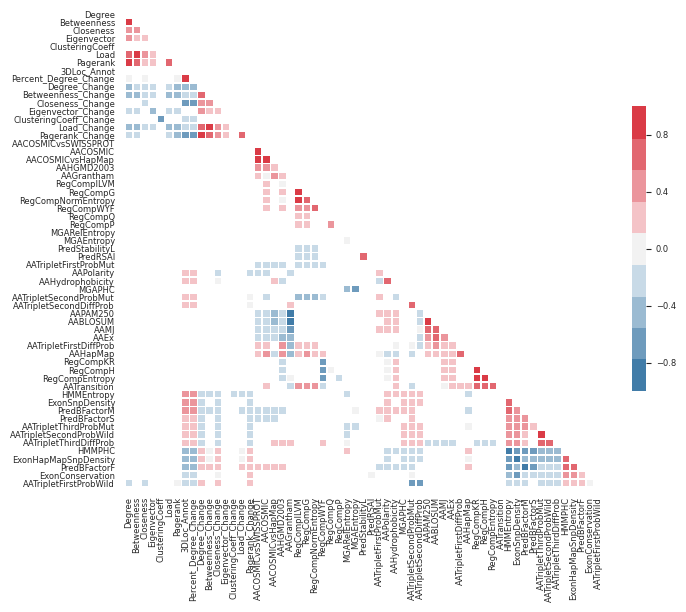

In [91]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr_df_filt2_reordered, dtype=np.bool)
# Note: make k=0 to hide (or k=1 to display) the diagonal
mask[np.triu_indices_from(mask,k=0)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(7.7, 7.4))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_df_filt2_reordered, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},
           xticklabels=True, yticklabels=True)
plt.savefig('../out/figures/Fig4d.pdf', transparent=True)
plt.show()